In [45]:
#importing stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [28]:
#Complete cell to create money metrics df for merging

#importing data from csz
tn_movie_budgets_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
tn_movie_budgets_df

#renaming it to work on
money_metrics_df = tn_movie_budgets_df

#funtion for cleaning
def clean_a_money_column(df, series_title):
    df[series_title] = df[series_title].str.replace('$','')
    df[series_title] = df[series_title].str.replace(',','')
    df[series_title] = pd.to_numeric(df[series_title])
    return df

#cleaning
money_metrics_df = clean_a_money_column(money_metrics_df,'worldwide_gross')
money_metrics_df = clean_a_money_column(money_metrics_df,'domestic_gross')
money_metrics_df = clean_a_money_column(money_metrics_df,'production_budget')


##Unique ID for later merging madness

money_metrics_df['mmdf_uni_id'] = money_metrics_df.index



#adding profit margin and ROI columns
money_metrics_df['Profit Margin']= (money_metrics_df['worldwide_gross']-money_metrics_df['production_budget'])/money_metrics_df['worldwide_gross']
money_metrics_df['ROI'] = (money_metrics_df['worldwide_gross']/money_metrics_df['production_budget'])

#setting profit margin desc as order for the table
money_metrics_df=money_metrics_df.sort_values(['Profit Margin'], ascending=False)

#dropping the zeros gross films

money_metrics_df = money_metrics_df[money_metrics_df['worldwide_gross'] != 0]

#creating year and month columns
#Vu's magic lambda, plus to numeric on the year 
money_metrics_df['Year'] = pd.to_numeric(money_metrics_df['release_date'].map(lambda x: x[-4:]))
money_metrics_df['Month'] = money_metrics_df['release_date'].map(lambda x: x[:3])

#I did this at some point and it breaks if I don't do it here
money_metrics_df.set_index('movie', inplace = True)
money_metrics_df.index.rename('Movie', inplace = True)

#vu's dupe check
movie_dupes = pd.Series(tn_movie_budgets_df['movie'].value_counts())
title_dupes = [movie_dupes.index[index] for index in list(range(len(movie_dupes))) if movie_dupes.values[index] > 1]


#making a new df to do the rename in
title_dupes_df = money_metrics_df[money_metrics_df.index.isin(title_dupes)]

#reset the index for easier editing
title_dupes_df.reset_index(inplace = True)

title_dupes_df.head(5)

#Making new columns, setting year to string for concat
title_dupes_df['Yearasastring'] = title_dupes_df['Year'].map(lambda x: str(x))
#Making the new title by combining the name of the movie and the year of release
title_dupes_df['New Title'] = title_dupes_df['Movie']+' '+title_dupes_df['Yearasastring'].copy()
#creating a new DF dropping all the columns we don't need 
title_dupes_df_merger = title_dupes_df[['mmdf_uni_id', 'New Title']]
#Don't actually know if we need this but, whatever.
money_metrics_df.reset_index(inplace = True)


#reintegrating new titles in a new df mergedf
mergedf = money_metrics_df.merge(title_dupes_df_merger, on = 'mmdf_uni_id', how= 'left')

#vu's slightly less magical de-duplicator

#new column for boolean
mergedf['is_title_NaN'] = mergedf['New Title'].isnull()

#for loop to rename 'Movie'
for movie_index in list(range(len(mergedf.index))):
    if  ~mergedf['is_title_NaN'][movie_index]:
        mergedf['Movie'][movie_index] = mergedf['New Title'][movie_index]

        
money_metrics_merge_ready = mergedf   


#### NOW OUTPUTS A DF CALLED money_metrics_merge_ready
#### TRY TO NOT MESS WITH THIS BLOCK, MAKE A COPY OF money_metrics_merge_ready
#### AND MESS WITH THAT        



<ipython-input-28-234ae0ea51b4>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  title_dupes_df['Yearasastring'] = title_dupes_df['Year'].map(lambda x: str(x))
<ipython-input-28-234ae0ea51b4>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  title_dupes_df['New Title'] = title_dupes_df['Movie']+' '+title_dupes_df['Yearasastring'].copy()
<ipython-input-28-234ae0ea51b4>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:

In [29]:
months_and_years_df = money_metrics_merge_ready
months_and_years_df


,Movie,id,release_date,production_budget,domestic_gross,worldwide_gross,mmdf_uni_id,Profit Margin,ROI,Year,Month,New Title,is_title_NaN
0,Deep Throat,46,"Jun 30, 1972",25000,45000000,45000000,5745,0.999444,1800.000000,1972,Jun,NaN,True
1,Mad Max,14,"Mar 21, 1980",200000,8750000,99750000,5613,0.997995,498.750000,1980,Mar,NaN,True
2,Paranormal Activity,93,"Sep 25, 2009",450000,107918810,194183034,5492,0.997683,431.517853,2009,Sep,NaN,True
3,The Gallows,80,"Jul 10, 2015",100000,22764410,41656474,5679,0.997599,416.564740,2015,Jul,NaN,True
4,The Blair Witch Project,7,"Jul 14, 1999",600000,140539099,248300000,5406,0.997584,413.833333,1999,Jul,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5410,Food Chains,36,"Nov 21, 2014",913000,0,176,5335,-5186.500000,0.000193,2014,Nov,NaN,True
5411,The Grimm Brothers' Snow White,53,"Aug 24, 1997",26000000,5000,5000,2152,-5199.000000,0.000192,1997,Aug,NaN,True
5412,Skin Trade,19,"May 8, 2015",9000000,1242,1242,3818,-7245.376812,0.000138,2015,May,NaN,True
5413,Perrierâs Bounty,82,"May 21, 2010",6600000,828,828,4081,-7970.014493,0.000125,2010,May,NaN,True


In [30]:
#A BLOCK OF USEFUL FUNCTIONS

#functions to pull years, months out of the data set. Can also be used for other column types?
#for now, use int types for the year
def year_iso (df, year):
    output_df = df[df['Year'] == year]
    return output_df

#for now, with money_metrics_df, use three letter abreviations for months
def month_iso (df, month):
    output_df = df[df['Month'] == month]
    return output_df



#Automating year pull outs on money_metrics_merge_ready, not sure the best way to do this, but for now, list of dataframes?
year_range = list(range(1915,2021))
year_range
year_keys = []
for i in year_range:
    keystring = ''
    keystring = str(i) + ' money_metrics_merge_ready'
    year_keys.append(keystring)

list_of_dfs_years = []
for i in year_range:
    df_out = year_iso (months_and_years_df, i)
    list_of_dfs_years.append(df_out)
    
years_and_dfs = dict(zip(year_keys,list_of_dfs_years))

#if we want monthly data

jan_mmmr_df = month_iso(months_and_years_df,'Jan')
feb_mmmr_df = month_iso(months_and_years_df,'Feb')
mar_mmmr_df = month_iso(months_and_years_df,'Mar')
apr_mmmr_df = month_iso(months_and_years_df,'Apr')
may_mmmr_df = month_iso(months_and_years_df,'May')
jun_mmmr_df = month_iso(months_and_years_df,'Jun')
jul_mmmr_df = month_iso(months_and_years_df,'Jul')
aug_mmmr_df = month_iso(months_and_years_df,'Aug')
sep_mmmr_df = month_iso(months_and_years_df,'Sep')
oct_mmmr_df = month_iso(months_and_years_df,'Oct')
nov_mmmr_df = month_iso(months_and_years_df,'Nov')
dec_mmmr_df = month_iso(months_and_years_df,'Dec')

month_list= ['January','February','March', 'April', 'May','June','July','August',
                           'September','October','November','December']

months_and_dfs = dict(zip( ['January','February','March', 'April', 'May','June','July','August',
                           'September','October','November','December'],
                         [jan_mmmr_df, feb_mmmr_df,mar_mmmr_df,apr_mmmr_df,may_mmmr_df,jun_mmmr_df,
                          jul_mmmr_df, aug_mmmr_df, sep_mmmr_df, oct_mmmr_df, nov_mmmr_df, dec_mmmr_df]))

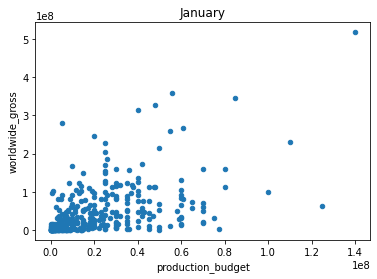

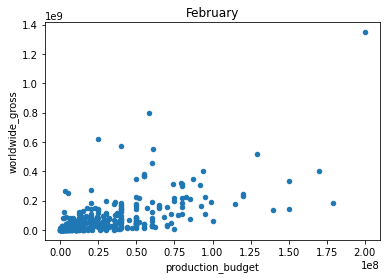

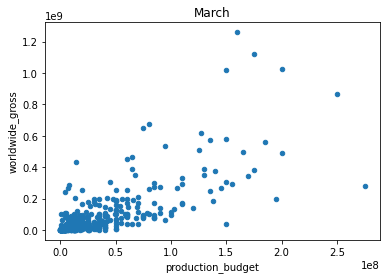

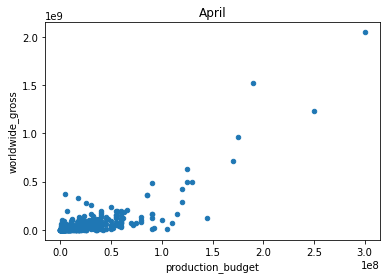

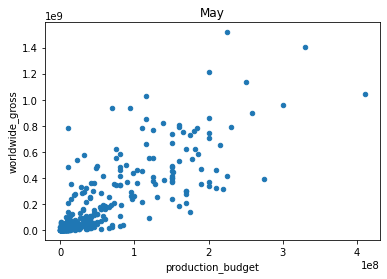

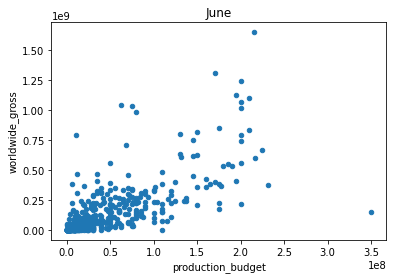

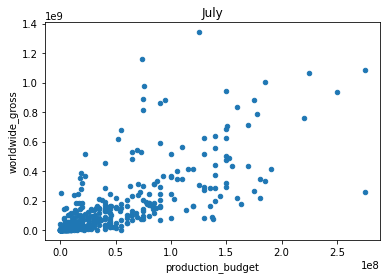

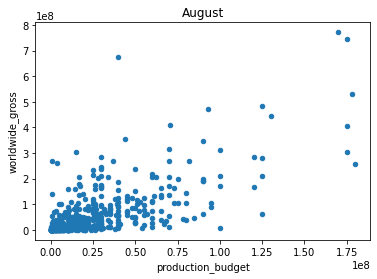

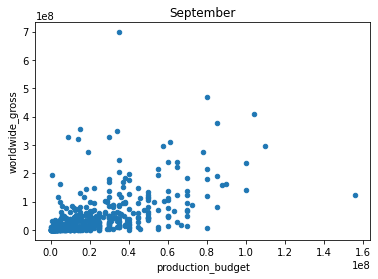

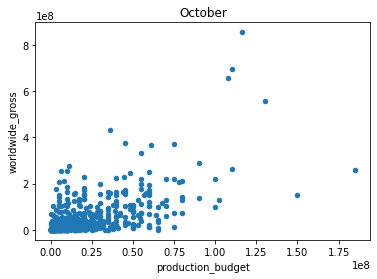

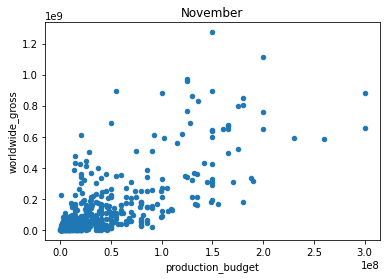

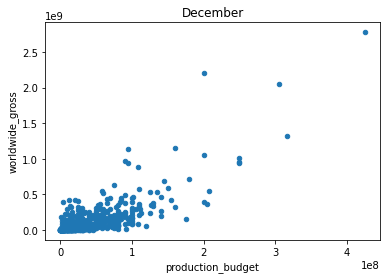

In [11]:
#Early Previs
for i in months_and_dfs:
    months_and_dfs[i].plot('production_budget' , 'worldwide_gross',  kind = 'scatter', title = i, );

In [31]:
mean_ROI_list= []

for i in months_and_dfs:
    mean_ROI_list.append(months_and_dfs[i]['ROI'].mean())
        
monthly_mean_ROI_dict=dict(zip(month_list, mean_ROI_list))    

''

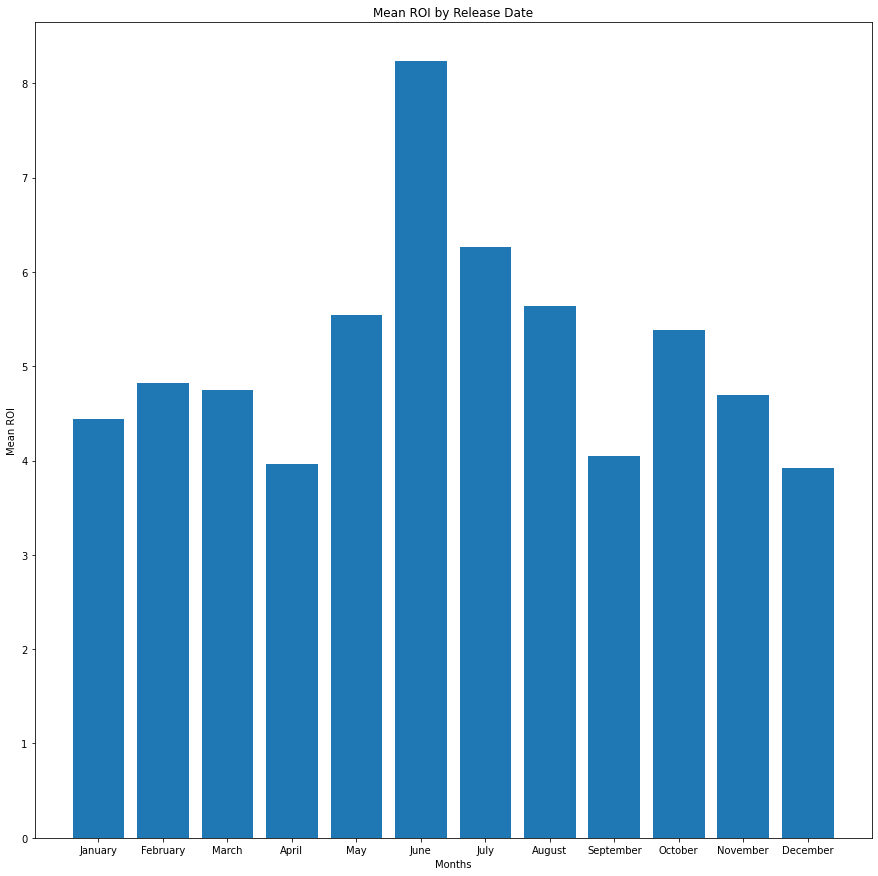

In [57]:
fig, ax = plt.subplots(figsize=(15,15))

ax.bar(monthly_mean_ROI_dict.keys(), monthly_mean_ROI_dict.values(), width=.8)
ax.set_xlabel('Months')
ax.set_ylabel('Mean ROI')
ax.set_title('Mean ROI by Release Date')



;
    